# KBO 타자 OPS 예측
- [데이콘 경진대회](https://github.com/wikibook/dacon/blob/master/ch01/batter_OPS_prediction.ipynb)(P.12~)
- [참고](https://dacon.io/competitions/official/235546/codeshare/578?page=1&dtype=recent)
- Background<br>
2016년 관중수가 800만명을 돌파한 프로야구는, 명실공히 한국 프로스포츠 최고의 인기 종목입니다.
프로야구의 인기 데이터 분석에 대한 인식이 높아짐에 따라 국내 여러 구단에서 데이터 사이언스 역할의 수요가 늘고 있습니다.
특히 야구에서는 특정 선수의 성적 변동성이 해마다 매우 크기 때문에 내년 성적을 예측하기 어렵습니다.
정말 못할 것이라고 생각했던 선수도 막상 내년에는 잘하고, 많은 지표가 리그 상위권이었던 선수가 내년에는 그렇지 않은 경우가 많습니다.
본 대회는 야구 데이터로 불확실성 문제를 해결하기 위해 2019년 타자들의 상반기 성적 예측을 목표로 합니다.

- Description<br>
2019년 타자들의 상반기 OPS를 예측하는 모델을 만들어 주세요. 2010년부터 1군 엔트리에 1번 이상 포함 되었던 타자들의 역대 정규시즌,
시범경기 성적 정보를 제공합니다(후반기 OPS 예측 대회는 전반기 종료 한 달 전 따로 오픈할 예정입니다)

- Data<br>약 350명의 타자들의 시즌별 성적, 생년월일, 몸무게, 키 등의 정보가 제공됩니다.

* [KBO기록실]( https://www.koreabaseball.com/Record/Player/HitterBasic/Basic1.aspx )과 같은 법적인 제약이 없는 외부 데이터 사용이 가능합니다.

   

- [Files]<br>
①    Regular_Season_Batter.csv : KBO에서 활약한 타자들의 역대 정규시즌 성적을 포함하여 몸무게, 키 ,생년월일 등의 기본정보<br>
②    Regular_Season_Batter_Day_by_Day.csv: KBO에서 활약한 타자들의 일자 별 정규시즌 성적<br>
③    Pre_Season_Batter.csv : KBO에서 활약한 타자들의 역대 시범경기(정규시즌 직전에 여는 연습경기) 성적<br>
④    submission.csv : 참가자들이 예측해야 할 타자의 이름과 아이디 목록

- 용어<br>
OBP : 출루율(타수대비 아웃되지 않고 1루로 출루한 비율)<br>
SLG : 장타율<br>
OPS : 출루율+장타율<br>
AB : 타자가 정규로 타격을 완료한 횟수<br>
BB : 볼넷으로 출루한 경우<br>
HBP : 사구(투수가 던진 공에 맞아서 출루한 경우)<br>
SF : 희생플라이(타자 본인은 아웃이지만 주자를 진루시켜준 경우)<br>
AVG : 타율(타수 대비 안타비율)<br>
1B, 2B, 3B : 1, 2,3루 진출<br>
HR : 홈런<br>
H : 안타(1B+2B+3B+HR)

In [2]:
!sudo apt-get install -y fonts-nanum > /dev/null
!sudo fc-cache -fv > /dev/null
!rm ~/.cache/matplotlib -rf > /dev/null
# 런타임 다시 시작

In [1]:
# 메모리 변수 모두 제거
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [ ]:
# 메모리 변수 확인
# globals()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

In [5]:
#그래프에서 마이너스 기호가 표시되게 하는 설정입니다.
matplotlib.rcParams['axes.unicode_minus'] = False

## 1. 탐색적 데이터 분석

In [6]:
from google.colab import drive
drive.mount('/content/mnt')

Mounted at /content/mnt


In [66]:
f = '/content/mnt/MyDrive/데이터/데이콘경진대회/62540_KBO_prediction_data'

### 1.1 프리시즌 데이터 분석

In [ ]:
# 프리시즌 데이터 로드
preseason_df = pd.read_csv(f"{f}/Pre_Season_Batter.csv")
# 정규시즌 데이터 로드
regular_season_df = pd.read_csv(f"{f}/Regular_Season_Batter.csv")
# 데이터 크기 확인
print(preseason_df.shape)
# 데이터 상단 출력
display(preseason_df.head())

(1393, 29)


,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,0,1,11,5,0,0,2,0,3,1,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959
1,1,강경학,2011,한화,0.000,4,2,2,0,0,0,0,0,1,0,1,0,2,1,0,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500
2,1,강경학,2014,한화,-,4,0,2,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,NaN
3,1,강경학,2015,한화,0.130,10,23,3,3,0,0,0,3,1,3,0,4,1,9,0,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416
4,1,강경학,2016,한화,0.188,14,32,4,6,1,1,0,9,2,1,2,0,1,10,0,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493


In [ ]:
# 데이터 기초통계량 확인
display(preseason_df.describe())

,batter_id,year,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1364.000000,1368.000000,1393.000000,1364.000000
mean,173.434314,2013.014358,8.705671,19.201723,2.679828,5.021536,0.954774,0.119885,0.391960,7.391960,2.430725,0.629576,0.291457,1.877961,0.330223,3.714286,0.447236,0.361012,0.317912,0.381910,0.676924
std,94.716851,4.166757,5.562686,13.395946,2.637212,4.232584,1.196904,0.379976,0.748557,6.538787,2.698122,1.146854,0.595522,2.053392,0.642204,3.180884,0.723364,0.269892,0.151489,0.729521,0.386933
min,0.000000,2002.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99.000000,2010.000000,6.000000,9.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.217000,0.250000,0.000000,0.472000
50%,178.000000,2014.000000,9.000000,18.000000,2.000000,4.000000,1.000000,0.000000,0.000000,6.000000,2.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.344500,0.333000,0.000000,0.675000
75%,254.000000,2017.000000,11.000000,28.000000,4.000000,8.000000,2.000000,0.000000,1.000000,11.000000,4.000000,1.000000,0.000000,3.000000,1.000000,5.000000,1.000000,0.478000,0.400000,1.000000,0.867000
max,344.000000,2018.000000,119.000000,183.000000,35.000000,51.000000,11.000000,4.000000,5.000000,68.000000,24.000000,9.000000,4.000000,21.000000,4.000000,36.000000,5.000000,4.000000,1.000000,5.000000,5.000000


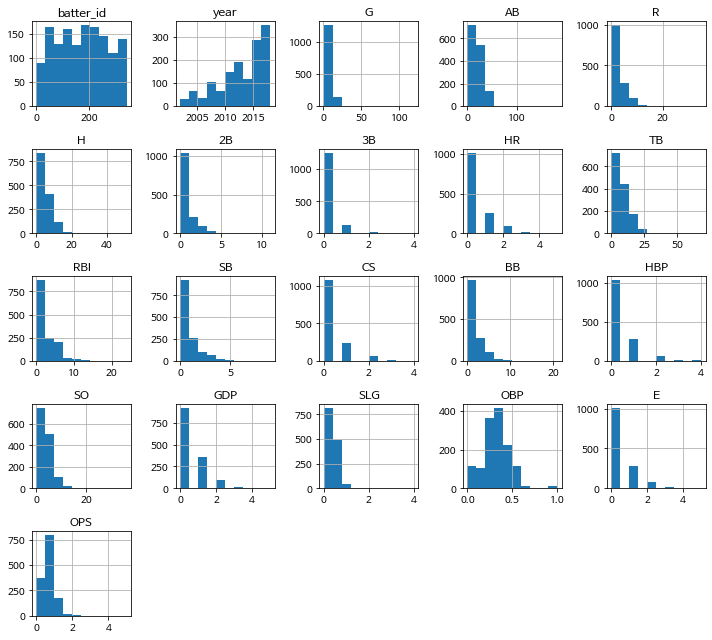

In [ ]:
# 데이터 시각화
preseason_df.hist(figsize=(10,9)) # 프리시즌
plt.tight_layout() # 그래프 간격 설정
plt.show()

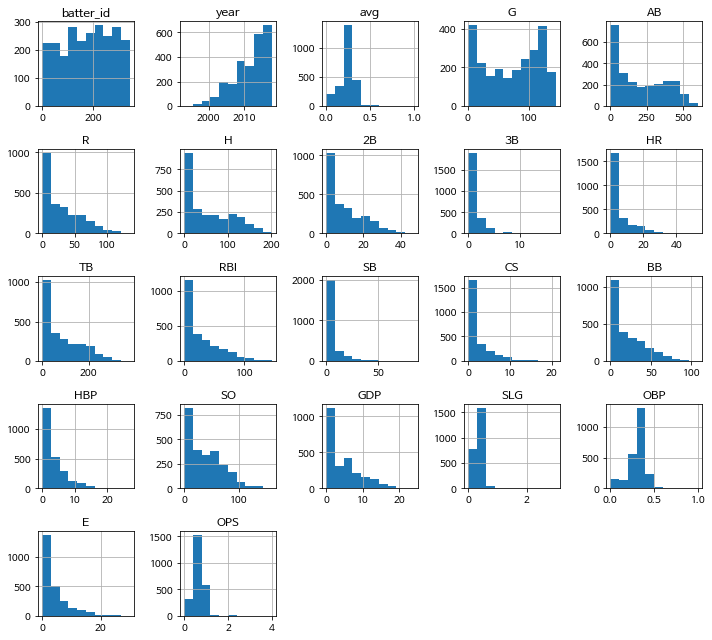

In [ ]:
# 데이터 시각화
regular_season_df.hist(figsize=(10,9)) # 정규시즌
plt.tight_layout() # 그래프 간격 설정
plt.show()

In [ ]:
regular_season_df.describe()

,batter_id,year,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,2454.000000,2454.000000,2428.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2428.000000,2430.000000,2454.000000,2428.000000
mean,178.079462,2011.614507,0.237559,72.535045,201.514670,29.912388,55.988183,9.863488,0.957620,5.504075,84.279136,27.788509,5.290139,2.335778,20.943765,3.424613,38.596985,4.603504,0.343826,0.306684,3.676447,0.649939
std,97.557947,4.992833,0.098440,45.093871,169.537029,28.778759,52.253844,9.871314,1.647193,7.989380,82.854200,29.602966,9.088580,3.194045,21.206113,4.132614,31.801466,4.713531,0.163335,0.111778,4.585248,0.261634
min,0.000000,1993.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,101.250000,2008.000000,0.203000,28.000000,38.250000,5.000000,8.000000,1.000000,0.000000,0.000000,10.000000,3.000000,0.000000,0.000000,3.000000,0.000000,10.000000,1.000000,0.267454,0.272727,0.000000,0.546000
50%,183.000000,2013.000000,0.255000,79.000000,163.000000,21.000000,40.000000,7.000000,0.000000,2.000000,56.000000,17.000000,2.000000,1.000000,14.000000,2.000000,33.000000,3.000000,0.360124,0.328592,2.000000,0.688637
75%,265.000000,2016.000000,0.291000,115.000000,357.500000,49.000000,100.000000,16.000000,1.000000,8.000000,146.000000,44.000000,6.000000,3.000000,34.000000,5.000000,60.000000,7.000000,0.436000,0.367000,5.000000,0.797234
max,344.000000,2018.000000,1.000000,144.000000,600.000000,135.000000,201.000000,47.000000,17.000000,53.000000,377.000000,146.000000,84.000000,21.000000,108.000000,27.000000,161.000000,24.000000,3.000000,1.000000,30.000000,4.000000


In [ ]:
# 정규시즌 데이터에서 2002년 이후의 연도별 기록된 선수의 수
regular_count = regular_season_df.groupby('year')['batter_id'].count().rename('regular')
# regular_season_df.groupby('year')['year'].count().rename('regular')

# 프리시즌 데이터에서 연도별 기록된 선수의 수
preseason_count = preseason_df.groupby('year')['batter_id'].count().rename('preseason')
pd.concat([regular_count,preseason_count, np.round(preseason_count/regular_count,2).rename(
        'ratio')], axis = 1).transpose().loc[:,2002:] # 2002년부터 봅니다.

# pd.concat([regular_count,preseason_count, np.round(preseason_count/regular_count,2).rename(
#         'ratio')], axis = 1).loc[2002:,:] # 2002년부터

year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
regular,43.00,54.00,68.00,73.00,85.00,98.00,115.00,124.00,130.00,151.0,174.0,194.00,186.00,207.00,213.00,217.00,227.0
preseason,12.00,19.00,28.00,37.00,36.00,43.00,61.00,66.00,72.00,75.0,87.0,104.00,117.00,134.00,153.00,167.00,182.0
ratio,0.28,0.35,0.41,0.51,0.42,0.44,0.53,0.53,0.55,0.5,0.5,0.54,0.63,0.65,0.72,0.77,0.8


In [ ]:
import time
start = time.time()
# numpy로 작업(판다스와 속도 비교)
yearList = np.unique(regular_season_df['year'])
yearListNum = []

for i in yearList: # nltk의 count함수를 이용하여 구할 수도 있음!
    cnt=0
    for k in regular_season_df['year']:
        if i==k:
            cnt+=1
    yearListNum.append([i, cnt])
# yearListNum

print(time.time()-start)

0.028537750244140625


In [ ]:
start = time.time()
regular_count = regular_season_df.groupby('year')['batter_id'].count()
# regular_count
print(time.time()-start)

0.002016782760620117


In [ ]:
## 정규시즌과 프리시즌 같은 값 비교방법
# 정규시즌과 프리시즌에 타자이름+년도를 합쳐서 새로운 필드 제작
# 비고라는 새로운 필드를 제작해서, join명령으로 정규시즌에 있는 타자이름+년도와 같은 자료를 프리시즌에서 가져옴
# 새로운 db=비고필드가 있는 db를 할당
# 비고 필드가 널값이 아닌 자료만 꺼내면 됨
# 상관도 만들면 됨

In [ ]:
# 타자의 이름과 연도를 이용해 새로운 인덱스를 생성
# 같은 해에 동명이인이 없다는 전제하에 진행
regular_season_df['new_idx'] = regular_season_df['batter_name'] + \
                               regular_season_df['year'].apply(str) # apply는 for문으로 작성가능
preseason_df['new_idx'] = preseason_df['batter_name'] + preseason_df['year'].apply(str)

In [ ]:
new_idx = []
for i,j in zip(regular_season_df['batter_name'], regular_season_df['year']):
    new_idx.append(i+str(j)) # apply이 작업

In [ ]:
# 새로운 인덱스의 교집합
intersection_idx = list(set(regular_season_df['new_idx']).intersection(preseason_df['new_idx']))

In [ ]:
# 교집합에 존재하는 데이터만 불러오기
regular_season_new = regular_season_df.loc[
    regular_season_df['new_idx'].apply(lambda x: x in intersection_idx)].copy()
regular_season_new = regular_season_new.sort_values(by = 'new_idx').reset_index(drop=True) 

# 비교를 위해 인덱스로 정렬
preseason_new = preseason_df.loc[preseason_df['new_idx'].apply(
    lambda x: x in intersection_idx)].copy()
preseason_new = preseason_new.sort_values(by = 'new_idx').reset_index(drop=True)

# 검정 코드
print(regular_season_new.shape, preseason_new.shape)
sum(regular_season_new['new_idx'] == preseason_new['new_idx'])

(1358, 30) (1358, 30)


1358

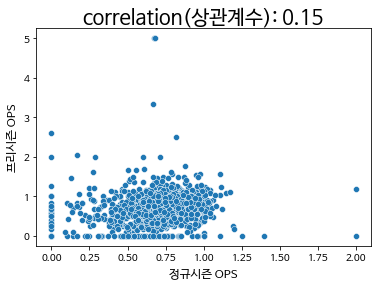

In [ ]:
# 정규시즌과 프리시즌의 상관관계 계산
correlation = regular_season_new['OPS'].corr(preseason_new['OPS'])
sns.scatterplot(regular_season_new['OPS'], preseason_new['OPS'])
plt.title('correlation(상관계수): '+str(np.round(correlation,2)), fontsize=20)
plt.xlabel("정규시즌 OPS",fontsize=12)
plt.ylabel("프리시즌 OPS",fontsize=12)
plt.show()
# 선형적인 모습을 띠고 있지 않기때문에 두 데이터가 서로 상관성이 매우 낮다는 것을 의미
# 따라서, 예측대상이 정규시즌의 성적이기 때문에 실제 분석에서는 프리시즌 데이터를 분석에서 제외

### 1.2 정규시즌 데이터 분석

In [ ]:
# 메모리 변수 모두 제거
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

f = '/content/mnt/MyDrive/데이터/데이콘경진대회/62540_KBO_prediction_data'

In [8]:
# 정규시즌 데이터 로드
regular_season_df = pd.read_csv(f"{f}/Regular_Season_Batter.csv")

In [9]:
display(regular_season_df.shape, regular_season_df.head(),regular_season_df.describe())

(2454, 29)

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902
1,1,강경학,2011,한화,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000
2,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686
3,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673
4,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489


,batter_id,year,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,2454.000000,2454.000000,2428.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2428.000000,2430.000000,2454.000000,2428.000000
mean,178.079462,2011.614507,0.237559,72.535045,201.514670,29.912388,55.988183,9.863488,0.957620,5.504075,84.279136,27.788509,5.290139,2.335778,20.943765,3.424613,38.596985,4.603504,0.343826,0.306684,3.676447,0.649939
std,97.557947,4.992833,0.098440,45.093871,169.537029,28.778759,52.253844,9.871314,1.647193,7.989380,82.854200,29.602966,9.088580,3.194045,21.206113,4.132614,31.801466,4.713531,0.163335,0.111778,4.585248,0.261634
min,0.000000,1993.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,101.250000,2008.000000,0.203000,28.000000,38.250000,5.000000,8.000000,1.000000,0.000000,0.000000,10.000000,3.000000,0.000000,0.000000,3.000000,0.000000,10.000000,1.000000,0.267454,0.272727,0.000000,0.546000
50%,183.000000,2013.000000,0.255000,79.000000,163.000000,21.000000,40.000000,7.000000,0.000000,2.000000,56.000000,17.000000,2.000000,1.000000,14.000000,2.000000,33.000000,3.000000,0.360124,0.328592,2.000000,0.688637
75%,265.000000,2016.000000,0.291000,115.000000,357.500000,49.000000,100.000000,16.000000,1.000000,8.000000,146.000000,44.000000,6.000000,3.000000,34.000000,5.000000,60.000000,7.000000,0.436000,0.367000,5.000000,0.797234
max,344.000000,2018.000000,1.000000,144.000000,600.000000,135.000000,201.000000,47.000000,17.000000,53.000000,377.000000,146.000000,84.000000,21.000000,108.000000,27.000000,161.000000,24.000000,3.000000,1.000000,30.000000,4.000000


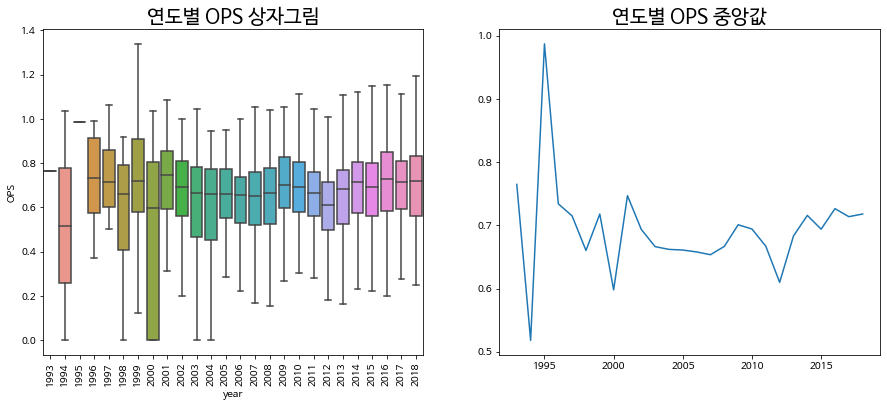

In [10]:
plt.figure(figsize=(15,6)) # 그래프 크기 조정
plt.subplot(1,2,1) # 1행 2열의 첫 번째(1행, 1열) 그래프
g = sns.boxplot(x="year", y="OPS", data=regular_season_df, showfliers=False)
g.set_title('연도별 OPS 상자그림', size = 20)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.subplot(1,2,2)
plt.plot(regular_season_df.groupby('year')['OPS'].median())
plt.title('연도별 OPS 중앙값', size = 20)
plt.show()

In [11]:
# regular_season_df.groupby('year')['year'].count()
pd.crosstab(regular_season_df['year'],'count').T

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
col_0,,,,,,,,,,,,,,,,,,,,,,,,,,
count,1,2,1,7,8,10,14,20,32,43,54,68,73,85,98,115,124,130,151,174,194,186,207,213,217,227


In [12]:
tmp = regular_season_df[regular_season_df.year==1998]
tmp[['batter_name', 'OPS']]

,batter_name,OPS
20,진갑용,0.662847
158,박재홍,0.920138
272,김동주,0.792486
890,박진만,0.547971
1081,송지만,0.788829
1101,신경현,0.125000
1824,장성호,0.844605
1963,정수성,0.000000
2085,조인성,0.657806
2199,최동수,0.361879


In [13]:
regular_season_df[regular_season_df.batter_name=='정수성'].describe()

,batter_id,year,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,14.0,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.00000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,272.0,2005.571429,0.212143,51.571429,76.500000,15.142857,18.428571,2.428571,0.714286,0.50000,23.785714,4.142857,9.071429,2.857143,5.214286,2.571429,16.928571,1.000000,0.258298,0.266970,0.785714,0.525268
std,0.0,4.535574,0.090114,35.943790,103.158392,15.917369,27.300928,4.164212,1.540658,0.94054,35.172495,6.187545,9.067815,2.957575,8.789667,5.287348,21.535174,2.385856,0.119985,0.101706,1.423893,0.211372
min,272.0,1998.000000,0.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.0,2002.250000,0.169750,23.750000,15.250000,3.000000,3.250000,0.000000,0.000000,0.00000,3.250000,0.000000,2.000000,0.250000,1.000000,0.000000,4.250000,0.000000,0.180195,0.254167,0.000000,0.440385
50%,272.0,2005.500000,0.234000,43.500000,26.500000,7.500000,4.500000,0.000000,0.000000,0.00000,6.000000,1.000000,6.500000,2.000000,1.000000,0.500000,6.500000,0.000000,0.267857,0.281886,0.000000,0.553058
75%,272.0,2008.750000,0.255750,84.250000,114.500000,24.500000,28.250000,4.000000,0.000000,0.75000,38.000000,7.750000,15.250000,5.750000,5.250000,2.750000,27.750000,1.000000,0.336832,0.309956,1.000000,0.643896
max,272.0,2013.000000,0.375000,118.000000,366.000000,53.000000,100.000000,14.000000,5.000000,3.00000,124.000000,19.000000,29.000000,9.000000,29.000000,20.000000,76.000000,9.000000,0.466667,0.444444,5.000000,0.819444


In [14]:
regular_season_df[(regular_season_df.batter_name=='정수성') & (regular_season_df.OPS==0)]

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
1963,272,정수성,1998,현대,0.0,6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,NaN,1978년 03월 04일,NaN,성동초-건대부중-덕수정보고-(초당대)-현대-우리-히어로즈-넥센,NaN,0.0


In [15]:
regular_season_df[regular_season_df.OPS==0]

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
1,1,강경학,2011,한화,0.0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.0
7,2,강구성,2013,NC,0.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,180cm/82kg,1993년 06월 09일,외야수(우투좌타),관산초-부천중-야탑고-NC-상무,9000만원,0.0
9,2,강구성,2016,NC,0.0,2,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,180cm/82kg,1993년 06월 09일,외야수(우투좌타),관산초-부천중-야탑고-NC-상무,9000만원,0.0
10,2,강구성,2017,NC,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,180cm/82kg,1993년 06월 09일,외야수(우투좌타),관산초-부천중-야탑고-NC-상무,9000만원,0.0
14,138,백승룡,2007,한화,0.0,8,4,3,0,0,0,0,0,0,0,0,0,0,2,1,0.0,0.0,0,NaN,1982년 08월 16일,NaN,사직초(부산극동리틀)-사직중-경남상고-경성대-한화-넥센,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,319,최형우,2004,삼성,0.0,2,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,180cm/106kg,1983년 12월 16일,외야수(우투좌타),진북초-전주동중-전주고-삼성-경찰-삼성,5000만원,0.0
2424,340,황선일,2006,LG,0.0,1,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0.0,0.0,0,NaN,1987년 02월 17일,NaN,군산중앙초-군산중-군산상고-LG-상무-LG,NaN,0.0
2449,344,황진수,2014,롯데,0.0,5,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.0
2450,344,황진수,2015,롯데,0.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.0


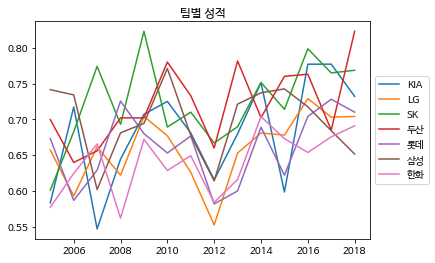

In [16]:
# 연도별 팀의 OPS 중앙값 계산
med_OPS_team = regular_season_df.pivot_table(index=['team'], columns='year',
                                             values='OPS', aggfunc='median')
# 2005년 이후에 결측치가 존재하지 않는 팀만 확인
team_idx = med_OPS_team.loc[:,2005:].isna().sum(axis=1) <= 0

plt.plot(med_OPS_team.loc[team_idx,2005:].T)
plt.legend(med_OPS_team.loc[team_idx,2005:].T.columns, 
           loc='center left', bbox_to_anchor=(1, 0.5)) # 그래프 범례를 그래프 밖에 위치
plt.title('팀별 성적')
plt.show() # 팀별로 성적에 차이가 있음.

In [17]:
regular_season_df['height/weight'].str.split('/').str[0]

0       177cm
1       180cm
2       180cm
3       180cm
4       180cm
        ...  
2449    181cm
2450    181cm
2451    181cm
2452    181cm
2453    181cm
Name: height/weight, Length: 2454, dtype: object

In [18]:
regular_season_df['height/weight'].apply(lambda x: str(x).split('/')[0][:3])

0       177
1       180
2       180
3       180
4       180
       ... 
2449    181
2450    181
2451    181
2452    181
2453    181
Name: height/weight, Length: 2454, dtype: object

In [19]:
import re

regular_season_df['weight'] = regular_season_df['height/weight'].apply(
    lambda x: int(re.findall('\d+',x.split('/')[1])[0]) if pd.notnull(x) else x)

regular_season_df['height'] = regular_season_df['height/weight'].apply(
    lambda x: int(re.findall('\d+',x.split('/')[0])[0]) if pd.notnull(x) else x)

print(regular_season_df['height/weight'][0], regular_season_df['height'][0],
      regular_season_df['weight'][0])

177cm/93kg 177.0 93.0


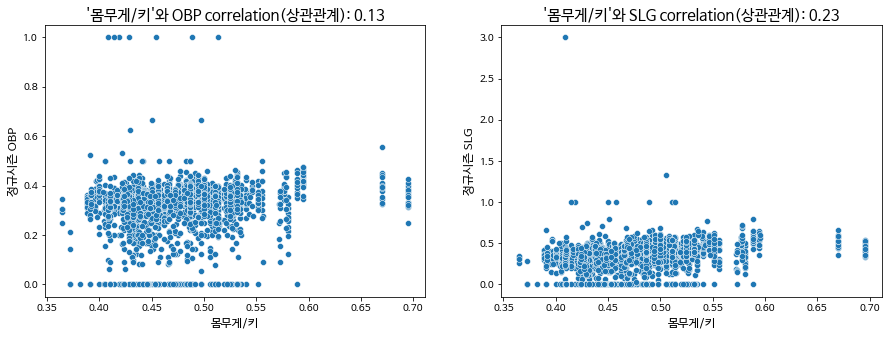

In [20]:
# 몸무게/키 계산
regular_season_df['weight_per_height'] = regular_season_df['weight'] / \
                                         regular_season_df['height']
plt.figure(figsize=(15, 5)) # 그래프 크기 조정
plt.subplot(1, 2, 1) # 1행 2열의 첫번째(1행, 1열) 그래프

# 몸무게/키와 OBP의 상관관계 계산
# 기대하는 결과 : 음의 상관관계
correlation = regular_season_df['weight_per_height'].corr(regular_season_df['OBP'])
sns.scatterplot(regular_season_df['weight_per_height'], regular_season_df['OBP'])
plt.title("'몸무게/키'와 OBP correlation(상관관계): " + str(np.round(correlation, 2)), \
          fontsize=15)
plt.ylabel('정규시즌 OBP',fontsize=12)
plt.xlabel('몸무게/키', fontsize=12)
plt.subplot(1, 2, 2)

# 몸무게/키와 SLG의 상관관계 계산
# 기대하는 결과 : 양의 상관관계
correlation = regular_season_df['weight_per_height'].corr(regular_season_df['SLG'])
sns.scatterplot(regular_season_df['weight_per_height'], regular_season_df['SLG'])
plt.title("'몸무게/키'와 SLG correlation(상관관계): " + str(np.round(correlation, 2)), \
          fontsize=15)
plt.ylabel('정규시즌 SLG', fontsize=12)
plt.xlabel('몸무게/키', fontsize=12)
plt.show()
# 선형적인 모습을 띠고 있지 않기때문에 몸무게와 키가 장타율과 출루율에 큰 영향을 끼치지 않음을 의미

In [21]:
# regular_season_df['position'].value_counts()
# 우투좌타 : 공격때는 좌타석에, 수비할 때는 오른손으로 공을 던지는 유형
# 이 분석이 OPS(출루와 관련된)이기 때문에 공격만 보면 됨.
# 우투좌타일 때는 좌타만 보면됨. 마지막 2글자만 보면 됨.

regular_season_df['position'].apply(
    lambda x: x[-3:-1] if pd.notnull(x) else x)

0       우타
1       좌타
2       좌타
3       좌타
4       좌타
        ..
2449    양타
2450    양타
2451    양타
2452    양타
2453    양타
Name: position, Length: 2454, dtype: object

In [22]:
# position
regular_season_df['pos']=regular_season_df['position'].apply(
    lambda x: x.split('(')[0] if pd.notnull(x) else x)

# 우타, 좌타, 양타
regular_season_df['hit_way'] = regular_season_df['position'].apply(
    lambda x: x[-3:-1] if pd.notnull(x) else x)
print(regular_season_df['position'][0], regular_season_df['pos'][0], 
      regular_season_df['hit_way'][0])

내야수(우투우타) 내야수 우타


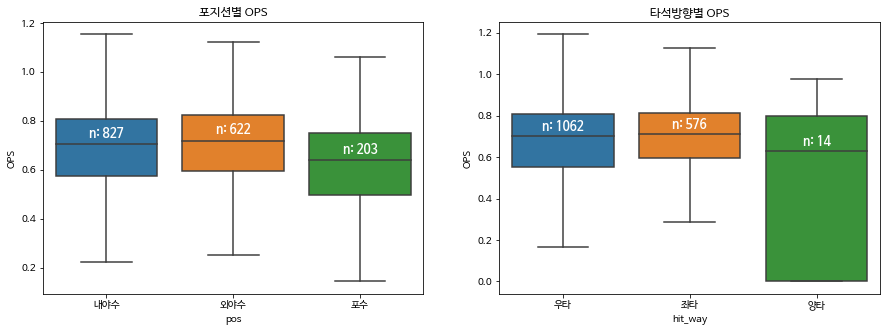

In [23]:
plt.figure(figsize=(15,5)) # 그래프 크기 조정
plt.subplot(1,2,1) # 1행 2열의 첫번째(1행, 1열) 그래프
ax = sns.boxplot(x='pos', y='OPS', data = regular_season_df, showfliers=False)

# position 별 OPS 중앙값
medians = regular_season_df.groupby(['pos'])['OPS'].median().to_dict()

# position별 관측치 수
nobs = regular_season_df['pos'].value_counts().to_dict()

# 키 값을 'n: 값' 형식으로 변환
for key in nobs: nobs[key] = "n: " + str(nobs[key])

# 그래프의 Xticks text 값 얻기
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]

# tick은 tick의 위치, label은 그에 해당하는 text 값
for label in ax.get_xticklabels():
    ax.text(xticks_labels.index(label.get_text()), 
            medians[label.get_text()] + 0.03, nobs[label.get_text()],
            horizontalalignment='center', size='large', color='w', weight='semibold')
    
ax.set_title('포지션별 OPS')

plt.subplot(1,2,2) # 1행 2열의 두 번째(1행, 2열) 그래프
ax = sns.boxplot(x='hit_way', y='OPS', data = regular_season_df, showfliers=False)

# 타자 방향별 OPS 중앙값
medians = regular_season_df.groupby(['hit_way'])['OPS'].median().to_dict()
# 타자 방향 관측치 수
nobs = regular_season_df['hit_way'].value_counts().to_dict()
# 키 값을 'n: 값' 형식으로 변환
for key in nobs: nobs[key] = "n: " + str(nobs[key])

# 그래프의 Xticks text 값 얻기
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]

# tick은 tick의 위치, label은 그에 해당하는 text 값
for label in ax.get_xticklabels():
    ax.text(xticks_labels.index(label.get_text()), medians[label.get_text()] + 0.03,
            nobs[label.get_text()], horizontalalignment='center', size='large',
            color='w', weight='semibold')
ax.set_title('타석방향별 OPS')

plt.show()

In [24]:
regular_season_df['career'].head()

0    쿠바 Ciego de Avila Maximo Gomez Baez(대)
1                         광주대성초-광주동성중-광주동성고
2                         광주대성초-광주동성중-광주동성고
3                         광주대성초-광주동성중-광주동성고
4                         광주대성초-광주동성중-광주동성고
Name: career, dtype: object

In [25]:
# career를 split
foreign_country = regular_season_df['career'].apply(
    lambda x: x.replace('-', ' ').split(' ')[0])

# 외국만 추출
foreign_country_list = list(set(foreign_country.apply(
    lambda x: np.nan if '초' in x else x)))

# 결측치 처리
foreign_country_list = [x for x in foreign_country_list if str(x) != 'nan']
foreign_country_list

['도미니카', '네덜란드', '미국', '캐나다', '쿠바']

In [26]:
regular_season_df['country'] = foreign_country
regular_season_df['country'] = regular_season_df['country'].apply(
    lambda x: x if pd.isnull(x)
                 else ('foreign' if x in foreign_country_list else 'korean'))
regular_season_df[['country']].head()

,country
0,foreign
1,korean
2,korean
3,korean
4,korean


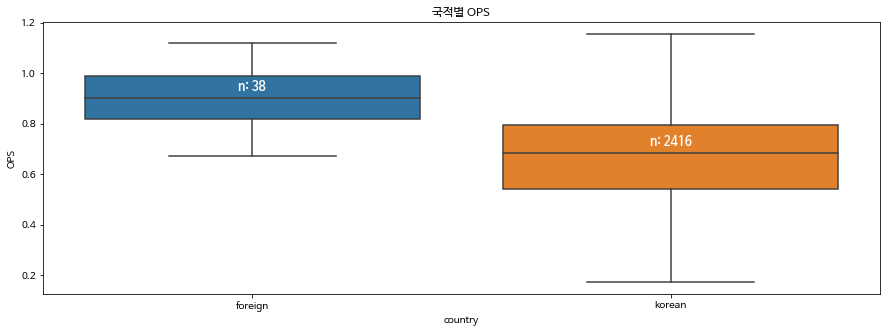

In [27]:
plt.figure(figsize=(15,5)) # 그래프 크기 조정
ax = sns.boxplot(x='country', y='OPS', data = regular_season_df, showfliers=False)

# 내외국인 별 OPS 중앙값 dict
medians = regular_season_df.groupby(['country'])['OPS'].median().to_dict()
# 내외국인 관측치 수 dict
nobs = regular_season_df['country'].value_counts().to_dict()
# 키 값을 'n: 값' 형식으로 변환 
for key in nobs: nobs[key] = "n: " + str(nobs[key])

# 그래프의 Xticks text 값 얻기
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]
    
for label in ax.get_xticklabels(): # tick은 tick의 위치, label은 그에 해당하는 text 값 
    ax.text(xticks_labels.index(label.get_text()), medians[label.get_text()] + 0.03, \
            nobs[label.get_text()], # x 좌표, y 좌표, 해당 text
            horizontalalignment='center', size='large', color='w', weight='semibold') 
ax.set_title('국적별 OPS')
plt.show()

In [28]:
regular_season_df['starting_salary'].value_counts()

10000만원     177
6000만원      117
3000만원      105
9000만원       97
5000만원       91
8000만원       89
30000만원      74
12000만원      62
4000만원       62
18000만원      54
7000만원       53
11000만원      49
13000만원      48
20000만원      46
25000만원      45
15000만원      41
16000만원      28
14000만원      26
28000만원      20
43000만원      17
45000만원      16
27000만원      15
21000만원      13
23000만원      12
33000만원      10
6500만원       10
100000달러      4
300000달러      3
50000달러       2
17000만원       1
Name: starting_salary, dtype: int64

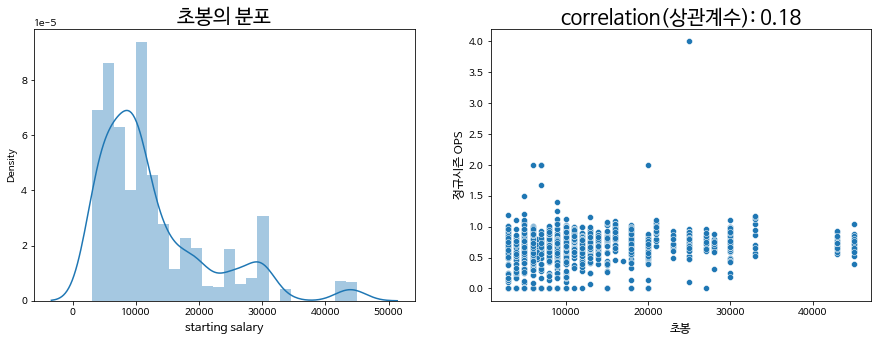

In [29]:
# 결측치라면 그대로 0으로 두고 ‘만원’이 포함되어 있다면 숫자만 뽑아서 초봉으로 넣어준다. 그외 만 원 단위가 아닌 초봉은 결측치로 처리한다.
regular_season_df['starting_salary'] = regular_season_df['starting_salary'].apply(
    lambda x: x if pd.isnull(x)
                 else(int(re.findall('\d+',x)[0]) if '만원' in x else np.nan))

plt.figure(figsize=(15,5)) # 그래프 크기 조정
plt.subplot(1,2,1) # 1행 2열의 첫 번째(1행, 1열) 그래프
b=sns.distplot(regular_season_df['starting_salary']. \
               loc[regular_season_df['starting_salary'].notnull()], hist=True)
b.set_xlabel("starting salary",fontsize=12)
b.set_title('초봉의 분포', fontsize=20)

plt.subplot(1,2,2) # 1행 2열의 두 번째(1행, 2열) 그래프

# 정규시즌과 프리시즌의 상관관계 계산
correlation = regular_season_df['starting_salary'].corr(regular_season_df['OPS'])
b = sns.scatterplot(regular_season_df['starting_salary'], regular_season_df['OPS'])
b.axes.set_title('correlation(상관계수): '+str(np.round(correlation,2)), fontsize=20)
b.set_ylabel("정규시즌 OPS",fontsize=12)
b.set_xlabel("초봉",fontsize=12)
plt.show()

### 1.3 일별 데이터 분석

In [30]:
day_by_day_df = pd.read_csv(f'{f}/Regular_Season_Batter_Day_by_Day_b4.csv')
display(day_by_day_df.shape, day_by_day_df.head())

(112273, 20)

,batter_id,batter_name,date,opposing_team,avg1,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,HBP,SO,GDP,avg2,year
0,0,가르시아,3.24,NC,0.333,3,1,1,0,0,0,0,0,0,1,0,1,0,0.333,2018
1,0,가르시아,3.25,NC,0.000,4,0,0,0,0,0,0,0,0,0,0,1,0,0.143,2018
2,0,가르시아,3.27,넥센,0.200,5,0,1,0,0,0,0,0,0,0,0,0,0,0.167,2018
3,0,가르시아,3.28,넥센,0.200,5,1,1,0,0,0,1,0,0,0,0,0,0,0.176,2018
4,0,가르시아,3.29,넥센,0.250,4,0,1,0,0,0,3,0,0,0,0,0,1,0.190,2018


In [31]:
# 날짜(date)를 ‘.’을 기준으로 나누고 첫 번째 값을 월(month)로 지정 
day_by_day_df['month'] = day_by_day_df['date'].apply(lambda x: str(x).split('.')[0])

# 각 연도의 월별 평균 누적 타율(avg2) 계산
agg_df = day_by_day_df.groupby(['year','month'])['avg2'].mean().reset_index()

# pivot_table을 이용해 데이터 변형
agg_df = agg_df.pivot_table(index=['month'], columns='year', values = 'avg2')
agg_df

year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
month,,,,,,,,,,,,,,,,,,
10,0.356400,0.269065,0.216583,0.203636,NaN,0.260985,0.249888,0.249638,0.033333,NaN,0.243526,0.246949,0.257841,0.273537,0.274042,0.282547,0.280289,0.277482
3,NaN,NaN,NaN,NaN,NaN,0.261714,0.261714,0.271982,NaN,0.239861,NaN,NaN,0.231236,0.210598,0.214485,0.257857,0.161979,0.238015
4,0.205217,0.319792,0.250296,0.259663,0.235317,0.267106,0.215703,0.261531,0.252546,0.262953,0.247133,0.234199,0.267994,0.259918,0.255175,0.266711,0.259430,0.263953
5,0.297157,0.267990,0.241491,0.237954,0.253527,0.264283,0.237329,0.262535,0.280842,0.272934,0.250877,0.247844,0.268355,0.273899,0.261307,0.275240,0.274374,0.274083
6,0.306926,0.275867,0.252290,0.248800,0.249913,0.264392,0.260600,0.270766,0.278781,0.274791,0.263264,0.254577,0.270533,0.283480,0.268999,0.276307,0.279060,0.280630
7,0.293171,0.266650,0.244230,0.251973,0.256396,0.262464,0.259171,0.264870,0.275054,0.265501,0.264829,0.261513,0.262812,0.275677,0.272685,0.283192,0.284565,0.280817
8,0.303489,0.270481,0.252319,0.249460,0.243570,0.265369,0.270258,0.265173,0.271796,0.271075,0.262048,0.258069,0.268122,0.282025,0.272377,0.283105,0.283283,0.283923
9,0.308636,0.248333,0.243780,0.203953,0.237058,0.258794,0.251022,0.252942,0.264468,0.265312,0.258500,0.251232,0.260571,0.272411,0.271629,0.276513,0.273213,0.277841


year,2011,2012,2013,2014,2015,2016,2017,2018
month,,,,,,,,
4,0.247133,0.234199,0.267994,0.259918,0.255175,0.266711,0.259430,0.263953
5,0.250877,0.247844,0.268355,0.273899,0.261307,0.275240,0.274374,0.274083
6,0.263264,0.254577,0.270533,0.283480,0.268999,0.276307,0.279060,0.280630
7,0.264829,0.261513,0.262812,0.275677,0.272685,0.283192,0.284565,0.280817
8,0.262048,0.258069,0.268122,0.282025,0.272377,0.283105,0.283283,0.283923
9,0.258500,0.251232,0.260571,0.272411,0.271629,0.276513,0.273213,0.277841


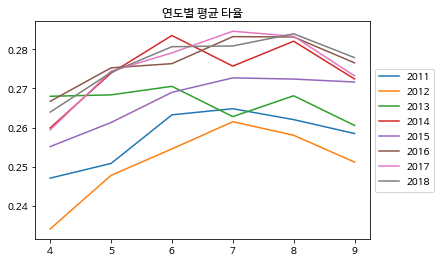

In [33]:
display(agg_df.iloc[2:, 10:])
plt.plot(agg_df.iloc[2:,10:]) # 2011~2018년 데이터만 이용
plt.legend(agg_df.iloc[2:,10:].columns,
           loc='center left', bbox_to_anchor=(1, 0.5)) # 범례 그래프 밖에 위치
plt.title('연도별 평균 타율')
plt.show()

## 2. 데이터 전처리

### 2.1 결측치 처리 및 데이터 오류 처리

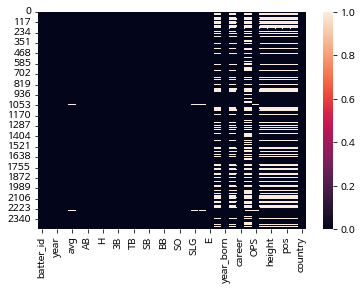

In [34]:
# 결측치 시각화
sns.heatmap(regular_season_df.isna())
plt.show()

In [35]:
pd.DataFrame(regular_season_df.isna().sum()).transpose()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,weight,height,weight_per_height,pos,hit_way,country
0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,24,0,802,0,802,0,1076,26,802,802,802,802,802,0


In [36]:
# 결측치에서 숫자 결측은 만약에 대체한다면 중앙값, 평균값 등으로 대체
# 문자는 중앙값, 평균값이 없음

# 수치형 타입의 변수 저장
numerics = [
    'int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # 모든 numeric(수치형) 타입
num_cols = regular_season_df.select_dtypes(include=numerics).columns

# 수치형 타입 변수 중 결측치가 하나라도 존재하는 행 출력
# isna().sum(axis=1) -> 열 기준의 결측치 개수
# df.loc[]를 통해 결측치 0개 이상 데이터를 추출
regular_season_df.loc[regular_season_df[num_cols].isna().sum(axis=1) > 0,num_cols].head()

,batter_id,year,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,starting_salary,OPS,weight,height,weight_per_height
0,0,2018,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519000,0.383000,9,NaN,0.902000,93.0,177.0,0.525424
12,138,2005,0.127,39,63,9,8,2,0,0,10,3,1,2,7,4,15,1,0.158730,0.256757,3,NaN,0.415487,NaN,NaN,NaN
13,138,2006,0.139,37,36,6,5,2,0,0,7,0,1,0,8,2,14,0,0.194444,0.326087,4,NaN,0.520531,NaN,NaN,NaN
14,138,2007,0.000,8,4,3,0,0,0,0,0,0,0,0,0,0,2,1,0.000000,0.000000,0,NaN,0.000000,NaN,NaN,NaN
15,138,2008,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0,NaN,0.000000,NaN,NaN,NaN


In [37]:
# 문자형 타입의 변수 저장
obj = ['object'] # 모든 문자형 타입
regular_season_df.select_dtypes(include=obj).columns

Index(['batter_name', 'team', 'height/weight', 'year_born', 'position',
       'career', 'pos', 'hit_way', 'country'],
      dtype='object')

In [38]:
def myfillna(obj):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    obj[obj.select_dtypes(include=numerics).columns] = \
    obj[obj.select_dtypes(include=numerics).columns].fillna(0)

In [39]:
obj = regular_season_df
myfillna(obj)
regular_season_df

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,weight,height,weight_per_height,pos,hit_way,country
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),0.0,0.902,93.0,177.0,0.525424,내야수,우타,foreign
1,1,강경학,2011,한화,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.000,72.0,180.0,0.400000,내야수,좌타,korean
2,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.686,72.0,180.0,0.400000,내야수,좌타,korean
3,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.673,72.0,180.0,0.400000,내야수,좌타,korean
4,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.489,72.0,180.0,0.400000,내야수,좌타,korean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,344,황진수,2014,롯데,0.000,5,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.000,82.0,181.0,0.453039,내야수,양타,korean
2450,344,황진수,2015,롯데,0.000,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.000,82.0,181.0,0.453039,내야수,양타,korean
2451,344,황진수,2016,롯데,0.000,11,10,2,0,0,0,0,0,0,0,1,0,0,5,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.000,82.0,181.0,0.453039,내야수,양타,korean
2452,344,황진수,2017,롯데,0.291,60,117,18,34,6,2,1,47,16,4,0,10,3,38,2,0.402,0.359,4,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.761,82.0,181.0,0.453039,내야수,양타,korean


In [40]:
# 수치형 변수에 포함되는 데이터 타입 선정
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# 정규 시즌 데이터에서 결측치를 0으로 채우기
regular_season_df[regular_season_df.select_dtypes(include=numerics).columns] = \
    regular_season_df[regular_season_df.select_dtypes(include=numerics).columns].fillna(0)
regular_season_df

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,weight,height,weight_per_height,pos,hit_way,country
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),0.0,0.902,93.0,177.0,0.525424,내야수,우타,foreign
1,1,강경학,2011,한화,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.000,72.0,180.0,0.400000,내야수,좌타,korean
2,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.686,72.0,180.0,0.400000,내야수,좌타,korean
3,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.673,72.0,180.0,0.400000,내야수,좌타,korean
4,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.489,72.0,180.0,0.400000,내야수,좌타,korean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,344,황진수,2014,롯데,0.000,5,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.000,82.0,181.0,0.453039,내야수,양타,korean
2450,344,황진수,2015,롯데,0.000,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.000,82.0,181.0,0.453039,내야수,양타,korean
2451,344,황진수,2016,롯데,0.000,11,10,2,0,0,0,0,0,0,0,1,0,0,5,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.000,82.0,181.0,0.453039,내야수,양타,korean
2452,344,황진수,2017,롯데,0.291,60,117,18,34,6,2,1,47,16,4,0,10,3,38,2,0.402,0.359,4,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.761,82.0,181.0,0.453039,내야수,양타,korean


In [41]:
obj = day_by_day_df
myfillna(obj)
day_by_day_df

,batter_id,batter_name,date,opposing_team,avg1,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,HBP,SO,GDP,avg2,year,month
0,0,가르시아,3.24,NC,0.333,3,1,1,0,0,0,0,0,0,1,0,1,0,0.333,2018,3
1,0,가르시아,3.25,NC,0.000,4,0,0,0,0,0,0,0,0,0,0,1,0,0.143,2018,3
2,0,가르시아,3.27,넥센,0.200,5,0,1,0,0,0,0,0,0,0,0,0,0,0.167,2018,3
3,0,가르시아,3.28,넥센,0.200,5,1,1,0,0,0,1,0,0,0,0,0,0,0.176,2018,3
4,0,가르시아,3.29,넥센,0.250,4,0,1,0,0,0,3,0,0,0,0,0,1,0.190,2018,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112268,344,황진수,6.23,LG,-,0,0,0,0,0,0,0,0,0,1,0,0,0,0.158,2018,6
112269,344,황진수,6.26,넥센,0.000,1,0,0,0,0,0,0,0,0,0,0,1,0,0.150,2018,6
112270,344,황진수,6.27,넥센,0.500,2,1,1,1,0,0,0,0,0,0,0,1,0,0.182,2018,6
112271,344,황진수,6.28,넥센,-,0,0,0,0,0,0,0,0,0,0,0,0,0,0.182,2018,6


In [42]:
# 수치형이 아닌 변수 추출
not_num_cols = [x for x in regular_season_df.columns if x not in num_cols]

# 수치형이 아닌 변수 중 결측치가 하나라도 존재하는 행 출력
# isna().sum(axis=1) -> 열 기준의 결측치 개수
# df.loc[]를 통해 결측치 0개 이상 데이터를 추출
regular_season_df.loc[regular_season_df[not_num_cols].isna().sum(axis=1) > 0,
                      not_num_cols].head()

,batter_name,team,height/weight,year_born,position,career,pos,hit_way,country
12,백승룡,한화,NaN,1982년 08월 16일,NaN,사직초(부산극동리틀)-사직중-경남상고-경성대-한화-넥센,NaN,NaN,korean
13,백승룡,한화,NaN,1982년 08월 16일,NaN,사직초(부산극동리틀)-사직중-경남상고-경성대-한화-넥센,NaN,NaN,korean
14,백승룡,한화,NaN,1982년 08월 16일,NaN,사직초(부산극동리틀)-사직중-경남상고-경성대-한화-넥센,NaN,NaN,korean
15,백승룡,한화,NaN,1982년 08월 16일,NaN,사직초(부산극동리틀)-사직중-경남상고-경성대-한화-넥센,NaN,NaN,korean
16,백승룡,한화,NaN,1982년 08월 16일,NaN,사직초(부산극동리틀)-사직중-경남상고-경성대-한화-넥센,NaN,NaN,korean


In [43]:
# 삭제할 데이터 추출
drop_idx = regular_season_df.loc[
    # 안타가 0개 이상이면서 장타율이 0인 경우
    ((regular_season_df['H'] > 0) & (regular_season_df['SLG']==0)) |
        
    # 안타가 0개 이상 혹은 볼넷이 0개 이상 혹은 몸에 맞은 볼이 0개 이상이면서
    # 출루율이 0인 경우
    (((regular_season_df['H'] > 0) |
      (regular_season_df['BB'] > 0) |
      (regular_season_df['HBP'] > 0)) &
     (regular_season_df['OBP'] == 0))
].index         

# 데이터 삭제
regular_season_df = regular_season_df.drop(drop_idx).reset_index(drop=True)
regular_season_df

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,weight,height,weight_per_height,pos,hit_way,country
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),0.0,0.902,93.0,177.0,0.525424,내야수,우타,foreign
1,1,강경학,2011,한화,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.000,72.0,180.0,0.400000,내야수,좌타,korean
2,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.686,72.0,180.0,0.400000,내야수,좌타,korean
3,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.673,72.0,180.0,0.400000,내야수,좌타,korean
4,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.489,72.0,180.0,0.400000,내야수,좌타,korean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442,344,황진수,2014,롯데,0.000,5,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.000,82.0,181.0,0.453039,내야수,양타,korean
2443,344,황진수,2015,롯데,0.000,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.000,82.0,181.0,0.453039,내야수,양타,korean
2444,344,황진수,2016,롯데,0.000,11,10,2,0,0,0,0,0,0,0,1,0,0,5,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.000,82.0,181.0,0.453039,내야수,양타,korean
2445,344,황진수,2017,롯데,0.291,60,117,18,34,6,2,1,47,16,4,0,10,3,38,2,0.402,0.359,4,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.761,82.0,181.0,0.453039,내야수,양타,korean


### 2.2 규정 타수 정의

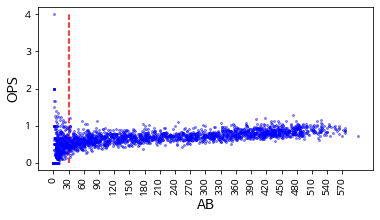

In [44]:
plt.figure(figsize=(6, 3)) # 크기 조정
plt.plot('AB', 'OPS', data=regular_season_df, linestyle='none', marker='o', 
         markersize=2, color='blue', alpha=0.4)
plt.xlabel('AB', fontsize=14)
plt.ylabel('OPS', fontsize=14)
plt.xticks(list(range(min(regular_season_df['AB']), max(regular_season_df['AB']), 30)),
           rotation=90)
plt.vlines(30,ymin=min(regular_season_df['OPS']),ymax=max(regular_season_df['OPS']),
           linestyles='dashed', colors='r')
plt.show()

In [45]:
# OPS 이상치 탐색을 위한 수치 정의
Q1 = regular_season_df['OPS'].quantile(0.25)
Q3 = regular_season_df['OPS'].quantile(0.75)
IQR = Q3 - Q1

# 실제 OPS 이상치 탐색
regular_season_df.loc[(regular_season_df['OPS'] < (Q1 - 1.5 * IQR)) |
                      (regular_season_df['OPS'] > (Q3 + 1.5 * IQR))].sort_values(
    by=['AB'], axis=0, ascending=False)[['batter_name','AB','year','OPS']].head(10)

,batter_name,AB,year,OPS
2329,테임즈,472,2015,1.293656
97,강정호,418,2014,1.200156
1318,유재신,33,2018,1.192000
416,김원섭,25,2005,0.116923
1543,이여상,22,2013,0.090909
681,문규현,18,2007,0.109000
578,김회성,17,2010,0.105000
1902,정병곤,15,2018,0.130000
1874,정경운,15,2018,0.130000
2384,현재윤,15,2014,1.229167


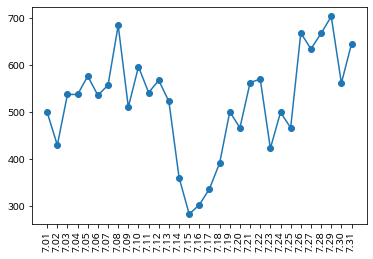

In [46]:
# 7.01~7.31 숫자 생성 후 반 올림
major_ticks = list(np.round(np.linspace(7.01,7.31, 31),2)) 

july = (day_by_day_df['date'] >= 7) & (day_by_day_df['date'] < 8) # 7월만 불러오는 index
plt.plot(major_ticks,
         day_by_day_df['date'].loc[july].value_counts().sort_index(), marker='o')
plt.xticks(major_ticks,rotation=90)
plt.show()

### 2.3 시간 변수

In [47]:
# 시간 변수를 생성하는 함수 정의
def lag_function(df, var_name, past):
    # df = 시간변수를 생성할 데이터 프레임
    # var_name = 시간변수 생성의 대상이 되는 변수 이름
    # past = 몇 년 전의 성적을 생성할지 결정 (정수형)
    df.reset_index(drop=True, inplace = True)
    
    #시간변수 생성
    df['lag'+str(past)+'_'+var_name] = np.nan;
    df['lag'+str(past)+'_'+'AB'] = np.nan
    
    for col in ['AB', var_name]:
        for i in range(0,(max(df.index)+1)):
            val = df.loc[(df['batter_name'] == df['batter_name'][i]) & 
                         (df['year'] == df['year'][i] - past), col]
            # 과거 기록이 결측치가 아니라면 값을 넣기
            if(len(val) != 0):
                df.loc[i, 'lag' + str(past) + '_' + col] = val.iloc[0]

    #30타수 미만 결측치 처리
    df.loc[df['lag' + str(past) + '_' + 'AB'] < 30, 
           'lag' + str(past) + '_' + var_name] = np.nan
    df.drop('lag' + str(past) + '_' + 'AB', axis = 1, inplace = True)

    return df

Text(0.5, 1.0, 'Diagonal Correlation HeatMap')

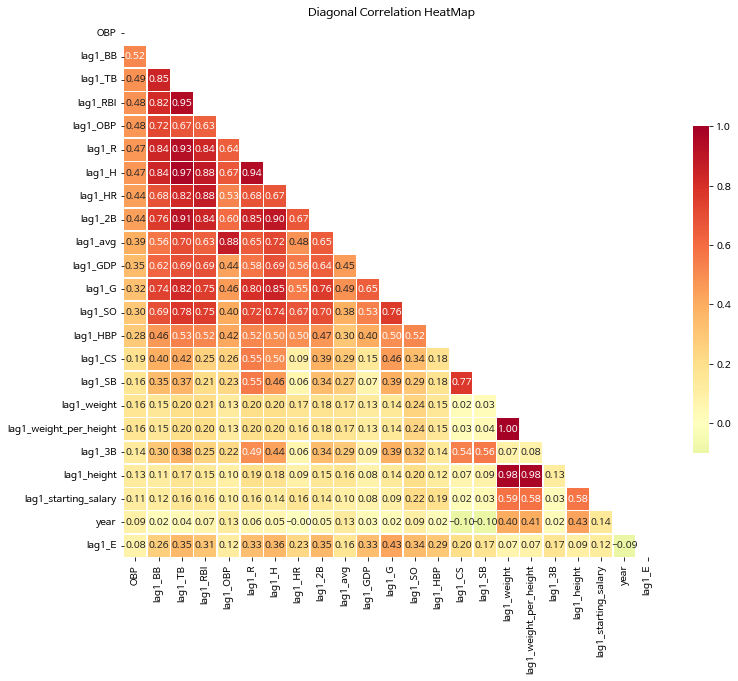

In [48]:
# 상관관계를 탐색할 변수 선택
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = list(regular_season_df.select_dtypes(include=numerics).drop(
    ['batter_id','year','OPS','SLG'], axis =1).columns)
regular_season_temp = regular_season_df[numeric_cols + ['year', 'batter_name']].copy()
regular_season_temp = regular_season_temp.loc[regular_season_temp['AB'] >= 30] # 교재 40페이지 참조

# 시간변수 생성 함수를 통한 지표별 1년 전 성적 추출
for col in numeric_cols:
    regular_season_temp = lag_function(regular_season_temp, col, 1)

numeric_cols.remove('OBP')
regular_season_temp.drop(numeric_cols, axis = 1, inplace= True)

# 상관관계 도출
corr_matrix = regular_season_temp.corr()
corr_matrix = corr_matrix.sort_values(by = 'OBP', axis = 0, ascending=False)
corr_matrix = corr_matrix[corr_matrix.index]

# 상관관계의 시각적 표현
f, ax = plt.subplots(figsize=(12, 12))
corr = regular_season_temp.select_dtypes(exclude=["object","bool"]).corr()

# 대각 행렬을 기준으로 한 쪽만 나타나게 설정해줍니다.
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

g = sns.heatmap(corr_matrix, cmap='RdYlGn_r', vmax= 1, mask=mask, 
center=0, annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Diagonal Correlation HeatMap")

In [49]:
#희생 플라이 구하기
#OBP(출루율) 계산 공식 이용하여 SF(희생 플라이)계산 >> (H+BB+HBP)/OBP-(AB+BB+HBP)
regular_season_df['SF'] = \
    regular_season_df[['H','BB','HBP']].sum(axis=1) / regular_season_df['OBP'] - \
    regular_season_df[['AB','BB','HBP']].sum(axis=1)
regular_season_df['SF'].fillna(0, inplace = True)
regular_season_df['SF'] = regular_season_df['SF'].apply(lambda x : round(x,0))

#한 타수당 평균 희생 플라이 계산 후 필요한 것만 추출
regular_season_df['SF_1'] = regular_season_df['SF'] / regular_season_df['AB']
regular_season_df_SF = regular_season_df[['batter_name','year','SF_1']]
regular_season_df_SF

,batter_name,year,SF_1
0,가르시아,2018,0.032787
1,강경학,2011,0.000000
2,강경학,2014,-0.000000
3,강경학,2015,0.009646
4,강경학,2016,0.009901
...,...,...,...
2442,황진수,2014,0.000000
2443,황진수,2015,0.000000
2444,황진수,2016,0.000000
2445,황진수,2017,0.008547


In [50]:
#day_by_day에서 연도별 선수의 시즌 전반기 출루율과 관련된 성적 합 구하기
sum_hf_yr_OBP = day_by_day_df.loc[day_by_day_df['date'] <= 7.18].groupby(
    ['batter_name','year'])['AB','H','BB','HBP'].sum().reset_index()

#day_by_day와 regular season에서 구한 희생 플라이 관련 데이터를 합치기
sum_hf_yr_OBP = sum_hf_yr_OBP.merge(regular_season_df_SF, how = 'left',
                                    on=['batter_name','year'])

#선수별 전반기 희생 플라이 수 계산
sum_hf_yr_OBP['SF'] = (sum_hf_yr_OBP['SF_1']*sum_hf_yr_OBP['AB']).apply(
    lambda x: round(x, 0))
sum_hf_yr_OBP.drop('SF_1', axis = 1, inplace = True)

#선수별 전반기 OBP(출루율) 계산
sum_hf_yr_OBP['OBP'] = sum_hf_yr_OBP[['H', 'BB', 'HBP']].sum(axis = 1) / \
                       sum_hf_yr_OBP[['AB', 'BB', 'HBP','SF']].sum(axis = 1)
# OBP 결측치를 0으로 처리 
sum_hf_yr_OBP['OBP'].fillna(0, inplace = True)

# 분석에 필요하지 않은 열 제거
sum_hf_yr_OBP = sum_hf_yr_OBP[['batter_name','year','AB','OBP']]
sum_hf_yr_OBP

,batter_name,year,AB,OBP
0,가르시아,2018,85,0.418367
1,강경학,2011,1,0.000000
2,강경학,2014,0,1.000000
3,강경학,2015,156,0.342541
4,강경학,2016,81,0.222222
...,...,...,...,...
1381,황진수,2012,4,0.400000
1382,황진수,2013,0,0.000000
1383,황진수,2016,9,0.000000
1384,황진수,2017,71,0.316456


### 2.4 추가 변수 생성

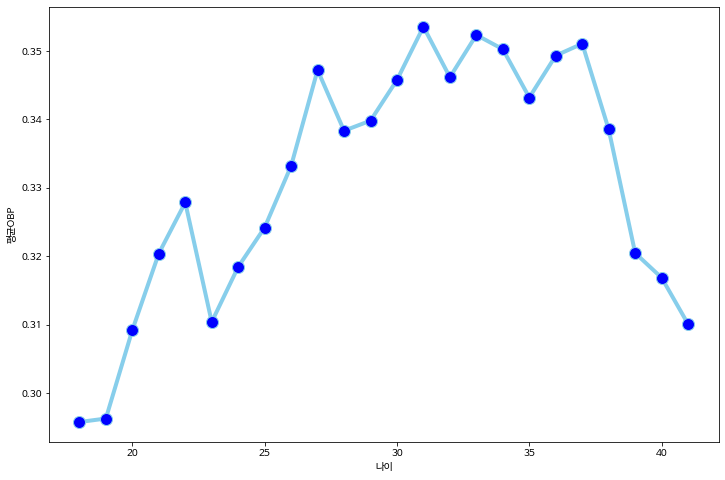

In [51]:
# 나이 변수 생성
regular_season_df['age'] = regular_season_df['year'] - \
                           regular_season_df['year_born'].apply(lambda x: int(x[:4]))

# 나이, 평균 출루율, 출루율 중위값으로 구성된 데이터프레임 구축
temp_df = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby('age').agg(
    {'OBP':['mean','median']}).reset_index()
temp_df.columns = temp_df.columns.droplevel()
temp_df.columns = ['age', 'mean_OBP', 'median_OBP']

# 나이에 따른 출루율 추이 시각화
plt.figure(figsize=(12,8))
plt.plot('age', 'mean_OBP', data=temp_df, marker='o', markerfacecolor='blue',
         markersize=12, color='skyblue', linewidth=4)
plt.ylabel('평균OBP')
plt.xlabel('나이')
plt.show()

In [52]:
# 나이를 포함한 변수 선택
sum_hf_yr_OBP = sum_hf_yr_OBP.merge(regular_season_df[['batter_name','year','age']],
                                    how = 'left', on=['batter_name','year'])

# 총 3년 전 성적까지 변수를 생성
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP, "OBP", 1)
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP, "OBP", 2)
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP, "OBP", 3)
sum_hf_yr_OBP

,batter_name,year,AB,OBP,age,lag1_OBP,lag2_OBP,lag3_OBP
0,가르시아,2018,85,0.418367,33,NaN,NaN,NaN
1,강경학,2011,1,0.000000,19,NaN,NaN,NaN
2,강경학,2014,0,1.000000,22,NaN,NaN,NaN
3,강경학,2015,156,0.342541,23,NaN,NaN,NaN
4,강경학,2016,81,0.222222,24,0.342541,NaN,NaN
...,...,...,...,...,...,...,...,...
1381,황진수,2012,4,0.400000,23,NaN,NaN,NaN
1382,황진수,2013,0,0.000000,24,NaN,NaN,NaN
1383,황진수,2016,9,0.000000,27,NaN,NaN,NaN
1384,황진수,2017,71,0.316456,28,NaN,NaN,NaN


### 2.5 데이터 사후 처리

In [53]:
round(sum_hf_yr_OBP[['lag1_OBP','lag2_OBP','lag3_OBP']].isna().sum() / \
      sum_hf_yr_OBP.shape[0], 2)

lag1_OBP    0.41
lag2_OBP    0.54
lag3_OBP    0.61
dtype: float64

In [54]:
#1. 선수별 OBP 평균
# SF = (H+BB+HBP) / OBP-(AB+BB+HBP)
# OBP = (H+BB+HBP) / (AB+BB+HBP+SF)
player_OBP_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'batter_name')['AB','H','BB','HBP','SF'].sum().reset_index()
player_OBP_mean['mean_OBP'] = player_OBP_mean[['H', 'BB', 'HBP']].sum(axis=1) / \
                            player_OBP_mean[['AB','BB','HBP','SF']].sum(axis=1)

#2. 시즌별 OBP 평균
season_OBP_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'year')['AB','H','BB','HBP','SF'].sum().reset_index()
season_OBP_mean['mean_OBP'] = season_OBP_mean[['H', 'BB', 'HBP']].sum(axis=1) / \
                              season_OBP_mean[['AB','BB','HBP','SF']].sum(axis=1)
season_OBP_mean = season_OBP_mean[['year', 'mean_OBP']]

#### player_OBP_mean(선수평균) 열 추가
sum_hf_yr_OBP = sum_hf_yr_OBP.merge(player_OBP_mean[['batter_name', 'mean_OBP']],
                                    how ='left', on="batter_name")
sum_hf_yr_OBP = \
    sum_hf_yr_OBP.loc[~sum_hf_yr_OBP['mean_OBP'].isna()].reset_index(drop=True)
sum_hf_yr_OBP

,batter_name,year,AB,OBP,age,lag1_OBP,lag2_OBP,lag3_OBP,mean_OBP
0,가르시아,2018,85,0.418367,33,NaN,NaN,NaN,0.383495
1,강경학,2011,1,0.000000,19,NaN,NaN,NaN,0.337880
2,강경학,2014,0,1.000000,22,NaN,NaN,NaN,0.337880
3,강경학,2015,156,0.342541,23,NaN,NaN,NaN,0.337880
4,강경학,2016,81,0.222222,24,0.342541,NaN,NaN,0.337880
...,...,...,...,...,...,...,...,...,...
1347,황진수,2012,4,0.400000,23,NaN,NaN,NaN,0.358779
1348,황진수,2013,0,0.000000,24,NaN,NaN,NaN,0.358779
1349,황진수,2016,9,0.000000,27,NaN,NaN,NaN,0.358779
1350,황진수,2017,71,0.316456,28,NaN,NaN,NaN,0.358779


In [55]:
# 결측치 처리하는 함수 정의
def lag_na_fill(data_set, var_name, past, season_var_mean_data):
    # data_Set: 이용할 데이터셋
    # var_name: 시간 변수를 만들 변수 이름
    # past: 몇 년 전 변수를 만들지 결정
    # season_var_name_mean_data season별로 var_name의 평균을 구한 데이터
  
    for i in range(0,len(data_set)):
        if np.isnan(data_set["lag"+str(past)+"_"+var_name][i]):
            data_set.loc[i,["lag"+str(past)+"_"+var_name]] = (
                data_set["mean" + "_" + var_name][i] + season_var_mean_data.loc[
                    season_var_mean_data['year'] == (data_set['year'][i] - past),
                    "mean_" + var_name].iloc[0]
                ) / 2
    return data_set

In [56]:
# 생성한 함수를 이용해 결측치 처리 진행
sum_hf_yr_OBP = lag_na_fill(sum_hf_yr_OBP, "OBP", 1, season_OBP_mean) # 1년 전 성적 대체
sum_hf_yr_OBP = lag_na_fill(sum_hf_yr_OBP, "OBP", 2, season_OBP_mean) # 2년 전 성적 대체
sum_hf_yr_OBP = lag_na_fill(sum_hf_yr_OBP, "OBP", 3, season_OBP_mean) # 3년 전 성적 대체
sum_hf_yr_OBP

,batter_name,year,AB,OBP,age,lag1_OBP,lag2_OBP,lag3_OBP,mean_OBP
0,가르시아,2018,85,0.418367,33,0.369982,0.375910,0.373119,0.383495
1,강경학,2011,1,0.000000,19,0.347434,0.348603,0.344259,0.337880
2,강경학,2014,0,1.000000,22,0.346682,0.337511,0.343131,0.337880
3,강경학,2015,156,0.342541,23,0.353425,0.346682,0.337511,0.337880
4,강경학,2016,81,0.222222,24,0.342541,0.353425,0.346682,0.337880
...,...,...,...,...,...,...,...,...,...
1347,황진수,2012,4,0.400000,23,0.353580,0.357883,0.359052,0.358779
1348,황진수,2013,0,0.000000,24,0.347960,0.353580,0.357883,0.358779
1349,황진수,2016,9,0.000000,27,0.360760,0.363874,0.357131,0.358779
1350,황진수,2017,71,0.316456,28,0.363552,0.360760,0.363874,0.358779


### 2.6 SLG 데이터 전처리

Text(0.5, 1.0, 'Diagonal Correlation HeatMap')

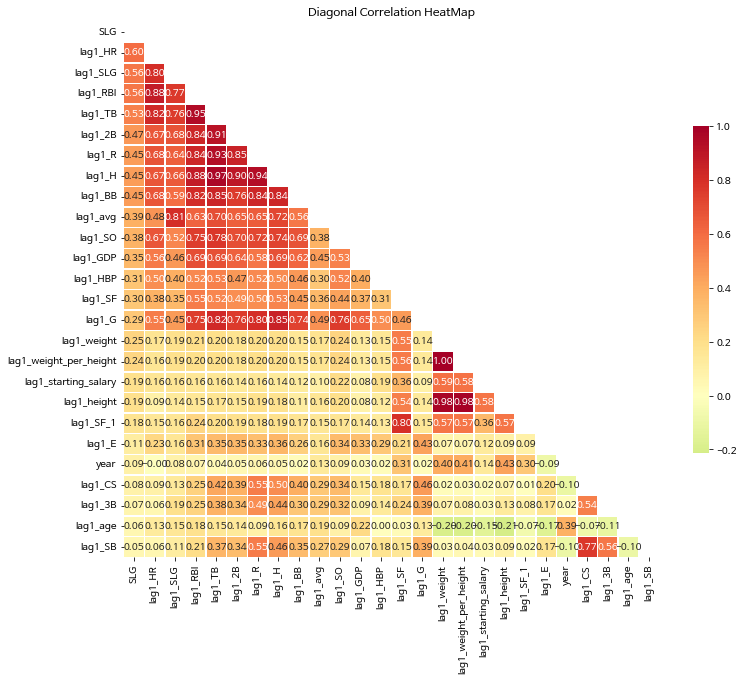

In [57]:
# 상관관계를 탐색할 변수 선택
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = list(regular_season_df.select_dtypes(include=numerics).drop(
    ['batter_id','year','OPS','OBP'], axis =1).columns)
regular_season_temp = regular_season_df[numeric_cols + ['year', 'batter_name']].copy()
regular_season_temp = regular_season_temp.loc[regular_season_temp['AB']>=30]

# 시간변수 생성 함수를 통한 지표별 1년 전 성적 추출
for col in numeric_cols:
    regular_season_temp = lag_function(regular_season_temp, col, 1)

numeric_cols.remove('SLG')
regular_season_temp.drop(numeric_cols, axis = 1, inplace=True)

# 상관관계 도출
corr_matrix = regular_season_temp.corr()
corr_matrix = corr_matrix.sort_values(by = 'SLG', axis = 0, ascending=False)
corr_matrix = corr_matrix[corr_matrix.index]

# 상관관계의 시각적 표현
f, ax = plt.subplots(figsize=(12, 12))
corr = regular_season_temp.select_dtypes(exclude=["object","bool"]).corr()

# 대각 행렬을 기준으로 한쪽만 나타나게 설정해줍니다.
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
g = sns.heatmap(corr_matrix, cmap='RdYlGn_r', vmax=1, mask=mask, center=0, annot=True,
                fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Diagonal Correlation HeatMap")

In [58]:
# day_by_day에서 연도별 선수의 시즌 전반기 장타율(SLG)과 관련된 성적 합 구하기
sum_hf_yr_SLG = day_by_day_df.loc[day_by_day_df['date'] <= 7.18].groupby(
    ['batter_name','year'])['AB','H','2B','3B', 'HR'].sum().reset_index()

# 전반기 장타율 계산
sum_hf_yr_SLG['SLG'] = \
    (sum_hf_yr_SLG['H'] - sum_hf_yr_SLG[['2B', '3B', 'HR']].sum(axis=1) +
     sum_hf_yr_SLG['2B']*2 + sum_hf_yr_SLG['3B']*3 + sum_hf_yr_SLG['HR']*4
     ) / sum_hf_yr_SLG['AB']

# SLG 결측치를 0으로 처리 
sum_hf_yr_SLG['SLG'].fillna(0, inplace=True)

# 필요한 칼럼만 불러오고 나이 계산
sum_hf_yr_SLG = sum_hf_yr_SLG[['batter_name','year','AB','SLG']]
sum_hf_yr_SLG = sum_hf_yr_SLG.merge(regular_season_df[['batter_name','year','age']],
                                    how='left', on=['batter_name','year'])
sum_hf_yr_SLG.head()

,batter_name,year,AB,SLG,age
0,가르시아,2018,85,0.552941,33
1,강경학,2011,1,0.000000,19
2,강경학,2014,0,0.000000,22
3,강경학,2015,156,0.333333,23
4,강경학,2016,81,0.222222,24


In [59]:
# 총 3년 전 성적까지 변수를 생성
sum_hf_yr_SLG = lag_function(sum_hf_yr_SLG, "SLG", 1)
sum_hf_yr_SLG = lag_function(sum_hf_yr_SLG, "SLG", 2)
sum_hf_yr_SLG = lag_function(sum_hf_yr_SLG, "SLG", 3)
display(sum_hf_yr_SLG.head())

round(sum_hf_yr_SLG[['lag1_SLG', 'lag2_SLG', 'lag3_SLG']].isna().sum()/\
      sum_hf_yr_SLG.shape[0], 2)

,batter_name,year,AB,SLG,age,lag1_SLG,lag2_SLG,lag3_SLG
0,가르시아,2018,85,0.552941,33,NaN,NaN,NaN
1,강경학,2011,1,0.000000,19,NaN,NaN,NaN
2,강경학,2014,0,0.000000,22,NaN,NaN,NaN
3,강경학,2015,156,0.333333,23,NaN,NaN,NaN
4,강경학,2016,81,0.222222,24,0.333333,NaN,NaN


lag1_SLG    0.41
lag2_SLG    0.54
lag3_SLG    0.61
dtype: float64

In [60]:
# 선수별 SLG 평균 데이터(player_SLG_mean)를 만듭니다
player_SLG_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'batter_name')['AB','H','2B','3B','HR'].sum().reset_index()
player_SLG_mean['mean_SLG'] = \
    (player_SLG_mean['H'] - player_SLG_mean[['2B','3B','HR']].sum(axis = 1) +
     player_SLG_mean['2B']*2 + player_SLG_mean['3B']*3 + player_SLG_mean['HR']*4
    ) / player_SLG_mean['AB']

# 시즌별 SLG 평균 데이터(season_SLG_mean)를 만듭니다
season_SLG_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'year')['AB','H','2B','3B','HR'].sum().reset_index()
season_SLG_mean['mean_SLG'] = \
    (season_SLG_mean['H'] - season_SLG_mean[['2B','3B','HR']].sum(axis = 1) + 
     season_SLG_mean['2B']*2 + season_SLG_mean['3B']*3 + season_SLG_mean['HR']*4
    ) / season_SLG_mean['AB']

# 선수 평균의 SLG(player_OBP_mean)를 새로운 변수로 더합니다.
sum_hf_yr_SLG = sum_hf_yr_SLG.merge(player_SLG_mean[['batter_name', 'mean_SLG']],
                                    how='left', on="batter_name")

# 선수 평균의 성적이 결측치이면 데이터에서 제거합니다.
sum_hf_yr_SLG = \
    sum_hf_yr_SLG.loc[~sum_hf_yr_SLG['mean_SLG'].isna()].reset_index(drop=True)

# 결측치 처리
sum_hf_yr_SLG = lag_na_fill(sum_hf_yr_SLG, "SLG", 1, season_SLG_mean) #1년전 성적 대체
sum_hf_yr_SLG = lag_na_fill(sum_hf_yr_SLG, "SLG", 2, season_SLG_mean) #2년전 성적 대체
sum_hf_yr_SLG = lag_na_fill(sum_hf_yr_SLG, "SLG", 3, season_SLG_mean) #3년전 성적 대체

display(sum_hf_yr_SLG.head())
round(sum_hf_yr_SLG[['lag1_SLG', 'lag2_SLG', 'lag3_SLG']].isna().sum()/\
      sum_hf_yr_SLG.shape[0], 2)

,batter_name,year,AB,SLG,age,lag1_SLG,lag2_SLG,lag3_SLG,mean_SLG
0,가르시아,2018,85,0.552941,33,0.481855,0.481498,0.476627,0.519126
1,강경학,2011,1,0.000000,19,0.372902,0.380882,0.361716,0.332527
2,강경학,2014,0,0.000000,22,0.362931,0.349344,0.359616,0.332527
3,강경학,2015,156,0.333333,23,0.389415,0.362931,0.349344,0.332527
4,강경학,2016,81,0.222222,24,0.333333,0.389415,0.362931,0.332527


lag1_SLG    0.0
lag2_SLG    0.0
lag3_SLG    0.0
dtype: float64

In [69]:
sum_hf_yr_OBP.to_csv(f'{f}/sum_hf_yr_OBP.csv', index=False)

In [70]:
sum_hf_yr_SLG.to_csv(f'{f}/sum_hf_yr_SLG.csv', index=False)